我想把过去14天的藻密度和叶绿素a浓度，不仅仅作为target，也作为feature。那么代码应该如何修改？

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from scipy import stats

# 读取数据
df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
df['date'] = pd.to_datetime(df['date'])

# 添加风力大于4级的特征
df['strong_wind'] = df['wind_power'].apply(lambda x: 1 if str(x).replace('级','').isdigit() and int(str(x).replace('级','')) >= 4 else 0)

# 添加天气one-hot编码
def split_weather(weather):
    if pd.isna(weather):
        return []
    return str(weather).split('-')

all_weather_types = set()
for weather in df['weather'].dropna():
    all_weather_types.update(split_weather(weather))

for weather_type in all_weather_types:
    df[f'weather_{weather_type}'] = df['weather'].apply(lambda x: 1 if pd.notna(x) and weather_type in split_weather(x) else 0)

# 选择需要分析相关性的列
target_cols = ['density_mean_y', 'density_lower_y', 'density_upper_y', 
               'chla_mean', 'chla_lower', 'chla_upper']

# 选择所有特征列,增加特征选择
exclude_cols = target_cols + ['date', 'density_mean_x', 'density_lower_x', 'density_upper_x', 'weather']
feature_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)

# 计算综合特征重要性并添加L1正则化
feature_importance = {}
l1_lambda = 0.01  # L1正则化系数

for target in target_cols:
    feature_importance[target] = {}
    
    for feature in feature_cols:
        # Spearman相关系数
        spearman_corr = df[feature].corr(df[target], method='spearman')
        
        # 互信息得分
        mi_score = mutual_info_regression(df[[feature]], df[target], random_state=42)[0]
        
        # 滞后相关性
        max_lag_corr = 0
        best_lag = 0
        for lag in range(1, 16):
            lag_corr = df[feature].shift(lag).corr(df[target], method='spearman')
            if not np.isnan(lag_corr) and abs(lag_corr) > abs(max_lag_corr):
                max_lag_corr = lag_corr
                best_lag = lag
                
        # 添加L1正则化项
        l1_penalty = l1_lambda * np.abs(spearman_corr)
        
        # 综合评分 = 0.35*相关系数 + 0.25*互信息 + 0.25*最大滞后相关 - 0.15*L1惩罚项
        composite_score = 0.35 * abs(spearman_corr) + 0.25 * mi_score + 0.25 * abs(max_lag_corr) - 0.15 * l1_penalty
        
        feature_importance[target][feature] = {
            'composite_score': composite_score,
            'spearman_corr': spearman_corr,
            'mi_score': mi_score,
            'max_lag_corr': max_lag_corr,
            'best_lag': best_lag,
            'l1_penalty': l1_penalty
        }

# 只选择最重要的特征(阈值筛选)
importance_threshold = 0.3
filtered_features = {}

for target in target_cols:
    filtered_features[target] = [
        feature for feature, metrics in feature_importance[target].items()
        if metrics['composite_score'] > importance_threshold
    ]

# 创建结果表格
results = []
for target in target_cols:
    sorted_features = sorted(feature_importance[target].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:10]  # 只保留前10个最重要的特征
    
    for feature, metrics in sorted_features:
        results.append({
            '目标变量': target,
            '特征': feature,
            '综合得分': round(metrics['composite_score'], 3),
            'Spearman相关系数': round(metrics['spearman_corr'], 3),
            '互信息得分': round(metrics['mi_score'], 3),
            '最大滞后相关': round(metrics['max_lag_corr'], 3),
            '最佳滞后期(天)': metrics['best_lag'],
            'L1惩罚': round(metrics['l1_penalty'], 3)
        })

# 输出结果表格
results_df = pd.DataFrame(results)
print("\n各目标变量的Top 10影响因子(添加L1正则化后):")
print(results_df.to_string(index=False))



各目标变量的Top 10影响因子(添加L1正则化后):
           目标变量              特征  综合得分  Spearman相关系数  互信息得分  最大滞后相关  最佳滞后期(天)  L1惩罚
 density_mean_y     temperature 0.453         0.561  0.450   0.580         7 0.006
 density_mean_y min_temperature 0.405         0.546  0.282   0.577         4 0.005
 density_mean_y max_temperature 0.399         0.533  0.267   0.585         3 0.005
 density_mean_y          oxygen 0.362        -0.440  0.329  -0.505        15 0.004
 density_mean_y              TN 0.350        -0.442  0.316  -0.468         4 0.004
 density_mean_y    conductivity 0.349        -0.412  0.401  -0.420         5 0.004
 density_mean_y              pH 0.279         0.335  0.306   0.342         1 0.003
 density_mean_y             aqi 0.219        -0.351  0.078  -0.309         1 0.004
 density_mean_y        aqiLevel 0.211        -0.330  0.095  -0.288         1 0.003
 density_mean_y              TP 0.205         0.272  0.216   0.224         1 0.003
density_lower_y     temperature 0.380         0.465  0.382

2024-11-15 19:56:51,219 - INFO - Successfully loaded data file
2024-11-15 19:56:51,220 - INFO - Start training model, sequence length: 14, prediction steps: 7
2024-11-15 19:56:51,235 - INFO - 特征数量: 38
2024-11-15 19:56:51,236 - INFO - 特征列表: ['temperature', 'min_temperature', 'max_temperature', 'oxygen', 'TN', 'conductivity', 'pH', 'aqi', 'aqiLevel', 'TP', 'density_mean_y_lag_1', 'density_mean_y_lag_2', 'density_mean_y_lag_3', 'density_mean_y_lag_4', 'density_mean_y_lag_5', 'density_mean_y_lag_6', 'density_mean_y_lag_7', 'density_mean_y_lag_8', 'density_mean_y_lag_9', 'density_mean_y_lag_10', 'density_mean_y_lag_11', 'density_mean_y_lag_12', 'density_mean_y_lag_13', 'density_mean_y_lag_14', 'chla_mean_lag_1', 'chla_mean_lag_2', 'chla_mean_lag_3', 'chla_mean_lag_4', 'chla_mean_lag_5', 'chla_mean_lag_6', 'chla_mean_lag_7', 'chla_mean_lag_8', 'chla_mean_lag_9', 'chla_mean_lag_10', 'chla_mean_lag_11', 'chla_mean_lag_12', 'chla_mean_lag_13', 'chla_mean_lag_14']
2024-11-15 19:57:15,585 - INFO 

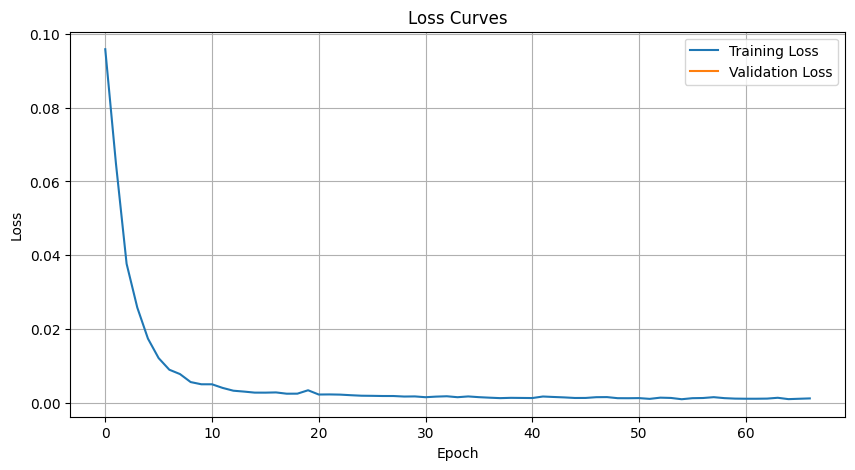

2024-11-15 19:58:29,062 - INFO - Final training loss: 0.0012
2024-11-15 19:58:29,166 - INFO - 
Prediction Accuracy Evaluation:
2024-11-15 19:58:29,167 - INFO - Algae Density RMSE: 0.0257, MAE: 0.0215


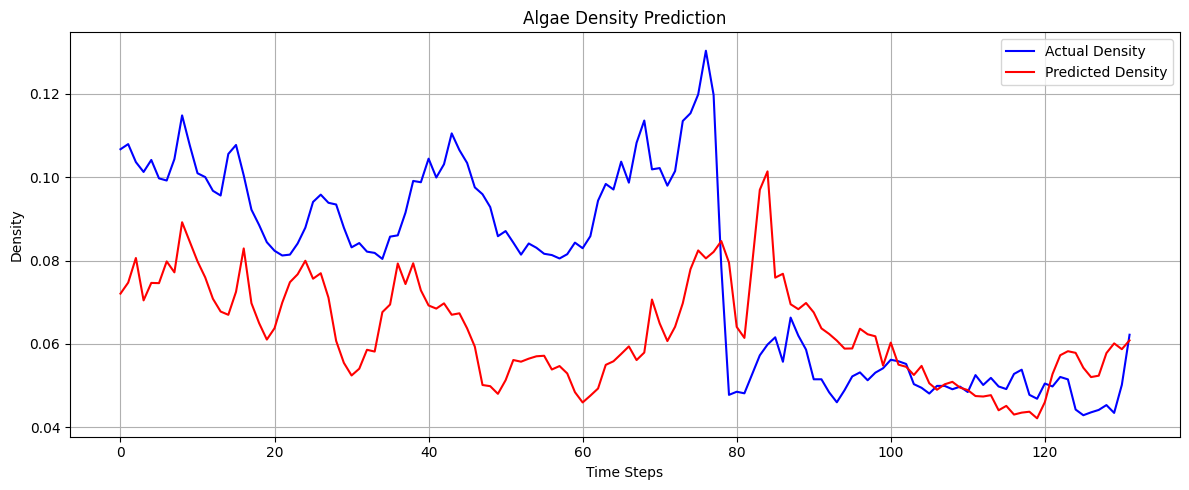

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import logging
from torch.optim.lr_scheduler import OneCycleLR

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.batch_norm1 = nn.BatchNorm1d(n_outputs)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.batch_norm2 = nn.BatchNorm1d(n_outputs)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.batch_norm1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.batch_norm2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        if self.downsample is not None:
            residual = self.downsample(residual)
            
        # 确保残差连接的维度匹配
        if out.size(2) != residual.size(2):
            # 如果序列长度不匹配，将较长的序列裁剪到较短的序列长度
            min_len = min(out.size(2), residual.size(2))
            out = out[:, :, :min_len]
            residual = residual[:, :, :min_len]

        return self.relu(out + residual)

class TCNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, kernel_size=3, dropout=0.2):
        super(TCNModel, self).__init__()
        self.batch_norm = nn.BatchNorm1d(input_size)
        
        layers = []
        num_channels = [hidden_size] * num_layers
        for i in range(num_layers):
            dilation = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size,
                                      stride=1, dilation=dilation,
                                      padding=(kernel_size-1) * dilation,
                                      dropout=dropout))
        
        self.tcn = nn.Sequential(*layers)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        # 调整输入维度从 [batch, seq_len, features] 到 [batch, features, seq_len]
        x = x.transpose(1, 2)
        x = self.batch_norm(x)
        
        # TCN层
        out = self.tcn(x)
        
        # 取最后一个时间步的输出
        out = out[:, :, -1]
        
        # 全连接层
        out = self.fc_layers(out)
        return out
    
def preprocess_data(df, sequence_length, prediction_step=3):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

    df = df.ffill()

    # 对weather列进行独热编码
    if 'weather' in df.columns:
        weather_dummies = pd.get_dummies(df['weather'], prefix='weather')
        df = pd.concat([df, weather_dummies], axis=1)
        df.drop('weather', axis=1, inplace=True)

    # 获取藻密度的TOP10特征
    sorted_features = sorted(feature_importance['density_mean_y'].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:10]
    density_features = [feature[0] for feature in sorted_features]
    
    # 检查特征是否存在于数据集中
    available_features = [f for f in density_features if f in df.columns]
    
    # 添加历史藻密度和叶绿素a浓度作为特征
    target_cols = ['density_mean_y', 'chla_mean']
    
    # 为每个目标变量创建历史特征
    for col in target_cols:
        for i in range(1, sequence_length + 1):
            shift_col = f'{col}_lag_{i}'
            df[shift_col] = df[col].shift(i)
            available_features.append(shift_col)
    
    logging.info(f"特征数量: {len(available_features)}")
    logging.info(f"特征列表: {available_features}")
    
    # 添加目标变量
    available_features.append('density_mean_y')
    df_features = df[available_features]

    # 删除包含NaN的行（由于创建滞后特征导致的）
    df_features = df_features.dropna()

    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_features), 
                           columns=available_features, 
                           index=df_features.index)

    # 分割2024年前后的数据
    train_data = df_scaled[df_scaled.index.year < 2024]
    test_data = df_scaled[df_scaled.index.year >= 2024]

    # 创建训练序列
    train_sequences = []
    for i in range(len(train_data) - sequence_length - prediction_step + 1):
        train_sequences.append(train_data.iloc[i:i+sequence_length].values)
    train_sequences = np.array(train_sequences)

    # 创建测试序列
    test_sequences = []
    for i in range(len(test_data) - sequence_length - prediction_step + 1):
        test_sequences.append(test_data.iloc[i:i+sequence_length].values)
    test_sequences = np.array(test_sequences)

    # 分割输入和目标
    X_train = train_sequences[:, :-prediction_step, :]
    y_train = train_sequences[:, -prediction_step, [available_features.index('density_mean_y')]]
    
    X_test = test_sequences[:, :-prediction_step, :]
    y_test = test_sequences[:, -prediction_step, [available_features.index('density_mean_y')]]

    return X_train, y_train, X_test, y_test, scaler, available_features

def create_dataloaders(X_train, y_train, X_test, y_test, batch_size):
    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs):
    model.train()
    best_loss = float('inf')
    patience = 15  # 增加早停耐心值
    no_improve = 0
    min_delta = 0.0001  # 添加最小改善阈值
    
    train_losses = []  # 记录训练损失
    val_losses = []    # 记录验证损失
    
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # 添加梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # 早停机制
        if avg_loss < best_loss - min_delta:  # 只有显著改善才重置计数器
            best_loss = avg_loss
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve >= patience:
            logging.info(f'Early stopping at epoch {epoch}')
            break
            
        if (epoch + 1) % 10 == 0:
            logging.info(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 打印最终损失
    logging.info(f'Final training loss: {train_losses[-1]:.4f}')
    if val_losses:
        logging.info(f'Final validation loss: {val_losses[-1]:.4f}')

def evaluate_lstm_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in test_loader:
            output = model(inputs)
            predictions.append(output.numpy())
            targets.append(target.numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    return predictions, targets

def plot_forecast(targets, predictions, title='Prediction Results', start_idx=0, end_idx=None):
    if end_idx is None:
        end_idx = len(targets)
        
    plt.figure(figsize=(12, 5))
    plt.plot(targets[start_idx:end_idx], label='Actual Density', color='blue')
    plt.plot(predictions[start_idx:end_idx], label='Predicted Density', color='red')
    plt.title('Algae Density Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    try:
        df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
        logging.info("Successfully loaded data file")

        batch_size = 32  # 减小batch size以增加随机性
        hidden_size = 256  # 增加隐藏层大小以处理更多特征
        num_layers = 3  # 增加TCN层数
        output_size = 1  # 只预测藻密度
        criterion = nn.HuberLoss()
        epochs = 200
        prediction_step = 7  # 预测未来7天
        sequence_length = 14  # 使用过去14天数据

        logging.info(f"Start training model, sequence length: {sequence_length}, prediction steps: {prediction_step}")
        X_train, y_train, X_test, y_test, scaler, features = preprocess_data(df, sequence_length, prediction_step)
        input_size = len(features)

        train_loader, test_loader = create_dataloaders(X_train, y_train, X_test, y_test, batch_size)

        model = TCNModel(input_size, hidden_size, num_layers, output_size, kernel_size=3, dropout=0.3)
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.001)  # 降低学习率和权重衰减
        
        # 修改学习率调度器
        scheduler = OneCycleLR(
            optimizer,
            max_lr=0.0005,
            epochs=epochs,
            steps_per_epoch=len(train_loader),
            pct_start=0.3,  # 调整学习率预热阶段
            div_factor=10.0  # 调整初始学习率与最大学习率的比例
        )

        train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs)

        predictions, targets = evaluate_lstm_model(model, test_loader)

        # 计算RMSE和MAE
        rmse_density = np.sqrt(mean_squared_error(targets, predictions))
        mae_density = mean_absolute_error(targets, predictions)

        logging.info("\nPrediction Accuracy Evaluation:")
        logging.info(f"Algae Density RMSE: {rmse_density:.4f}, MAE: {mae_density:.4f}")

        # 绘制预测结果
        plot_forecast(targets, predictions, title='TCN Prediction Results')

    except Exception as e:
        logging.error(f"Program error: {str(e)}")
        import traceback
        logging.error(traceback.format_exc())

if __name__ == "__main__":
    main()

2024-11-15 20:01:39,485 - INFO - Successfully loaded data file
2024-11-15 20:01:39,487 - INFO - Start training model, sequence length: 14, prediction steps: 7
2024-11-15 20:01:39,494 - INFO - Number of density features: 10
2024-11-15 20:01:39,495 - INFO - Density features: ['temperature', 'min_temperature', 'max_temperature', 'oxygen', 'TN', 'conductivity', 'pH', 'aqi', 'aqiLevel', 'TP']
2024-11-15 20:01:39,677 - INFO - 特征数量: 11
2024-11-15 20:01:39,678 - INFO - 特征列表: ['temperature', 'min_temperature', 'max_temperature', 'oxygen', 'TN', 'conductivity', 'pH', 'aqi', 'aqiLevel', 'TP', 'density_mean_y']
2024-11-15 20:01:39,678 - INFO - 
训练提前1天预报模型
2024-11-15 20:01:48,203 - INFO - Epoch 10/200, Average Loss: 0.0090
2024-11-15 20:01:58,765 - INFO - Epoch 20/200, Average Loss: 0.0031
2024-11-15 20:02:08,984 - INFO - Epoch 30/200, Average Loss: 0.0023
2024-11-15 20:02:20,182 - INFO - Epoch 40/200, Average Loss: 0.0017
2024-11-15 20:02:29,507 - INFO - Epoch 50/200, Average Loss: 0.0014
2024-11-

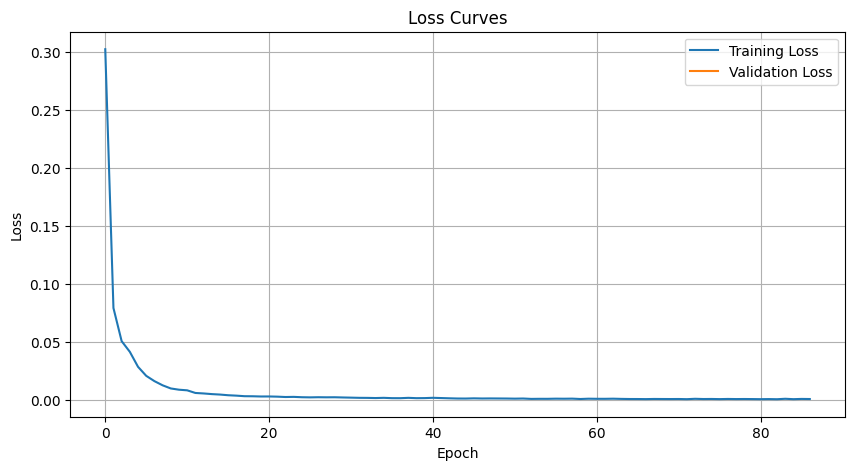

2024-11-15 20:03:06,801 - INFO - Final training loss: 0.0009
2024-11-15 20:03:06,883 - INFO - 提前1天预报 - RMSE: 0.0393, MAE: 0.0332
2024-11-15 20:03:06,886 - INFO - 
训练提前2天预报模型
2024-11-15 20:03:19,194 - INFO - Epoch 10/200, Average Loss: 0.0083
2024-11-15 20:03:31,978 - INFO - Epoch 20/200, Average Loss: 0.0028
2024-11-15 20:03:46,453 - INFO - Epoch 30/200, Average Loss: 0.0020
2024-11-15 20:04:01,930 - INFO - Epoch 40/200, Average Loss: 0.0018
2024-11-15 20:04:17,675 - INFO - Epoch 50/200, Average Loss: 0.0014
2024-11-15 20:04:29,456 - INFO - Epoch 60/200, Average Loss: 0.0011
2024-11-15 20:04:40,988 - INFO - Epoch 70/200, Average Loss: 0.0012
2024-11-15 20:04:52,608 - INFO - Early stopping at epoch 79


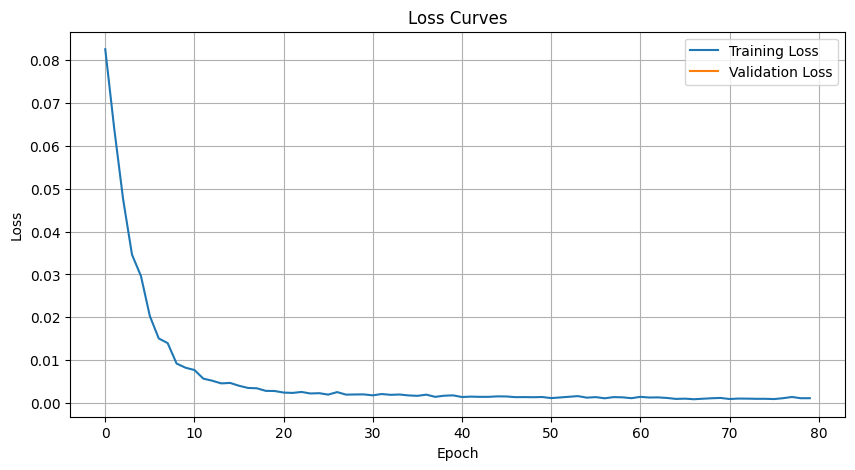

2024-11-15 20:04:52,754 - INFO - Final training loss: 0.0011
2024-11-15 20:04:52,811 - INFO - 提前2天预报 - RMSE: 0.0336, MAE: 0.0263
2024-11-15 20:04:52,813 - INFO - 
训练提前3天预报模型
2024-11-15 20:05:02,502 - INFO - Epoch 10/200, Average Loss: 0.0075
2024-11-15 20:05:14,001 - INFO - Epoch 20/200, Average Loss: 0.0036
2024-11-15 20:05:26,315 - INFO - Epoch 30/200, Average Loss: 0.0026
2024-11-15 20:05:41,224 - INFO - Epoch 40/200, Average Loss: 0.0019
2024-11-15 20:05:51,335 - INFO - Epoch 50/200, Average Loss: 0.0016
2024-11-15 20:06:03,666 - INFO - Epoch 60/200, Average Loss: 0.0012
2024-11-15 20:06:15,165 - INFO - Epoch 70/200, Average Loss: 0.0011
2024-11-15 20:06:26,526 - INFO - Epoch 80/200, Average Loss: 0.0010
2024-11-15 20:06:37,172 - INFO - Early stopping at epoch 87


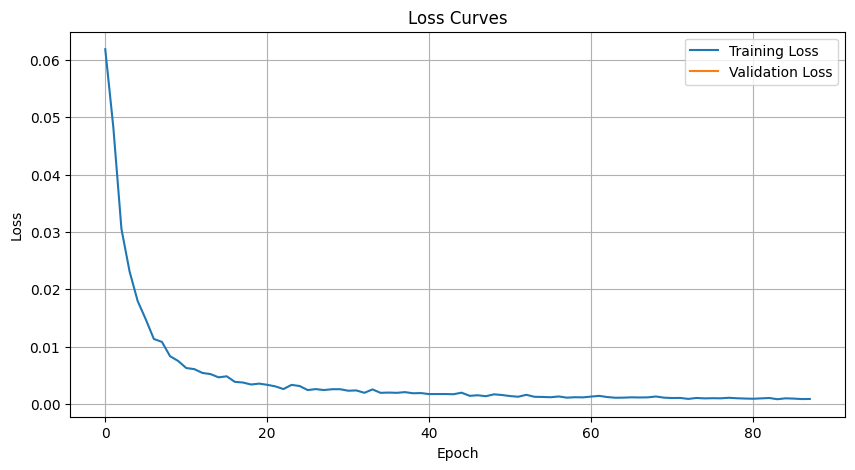

2024-11-15 20:06:37,568 - INFO - Final training loss: 0.0009
2024-11-15 20:06:37,635 - INFO - 提前3天预报 - RMSE: 0.0430, MAE: 0.0366
2024-11-15 20:06:37,639 - INFO - 
训练提前4天预报模型
2024-11-15 20:06:51,484 - INFO - Epoch 10/200, Average Loss: 0.0089
2024-11-15 20:07:04,458 - INFO - Epoch 20/200, Average Loss: 0.0036
2024-11-15 20:07:17,655 - INFO - Epoch 30/200, Average Loss: 0.0022
2024-11-15 20:07:27,808 - INFO - Epoch 40/200, Average Loss: 0.0017
2024-11-15 20:07:39,356 - INFO - Epoch 50/200, Average Loss: 0.0015
2024-11-15 20:07:52,627 - INFO - Epoch 60/200, Average Loss: 0.0011
2024-11-15 20:08:03,412 - INFO - Epoch 70/200, Average Loss: 0.0010
2024-11-15 20:08:12,845 - INFO - Epoch 80/200, Average Loss: 0.0011
2024-11-15 20:08:15,029 - INFO - Early stopping at epoch 81


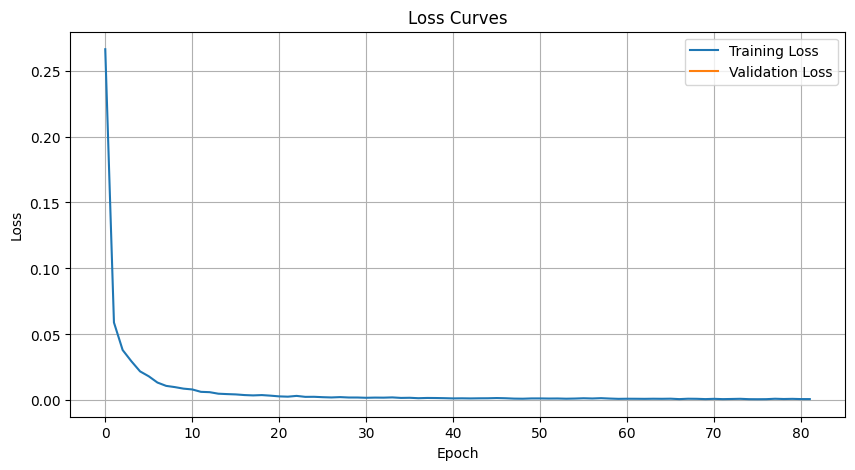

2024-11-15 20:08:15,186 - INFO - Final training loss: 0.0010
2024-11-15 20:08:15,229 - INFO - 提前4天预报 - RMSE: 0.0415, MAE: 0.0348
2024-11-15 20:08:15,230 - INFO - 
训练提前5天预报模型
2024-11-15 20:08:23,644 - INFO - Epoch 10/200, Average Loss: 0.0069
2024-11-15 20:08:32,822 - INFO - Epoch 20/200, Average Loss: 0.0027
2024-11-15 20:08:43,217 - INFO - Epoch 30/200, Average Loss: 0.0019
2024-11-15 20:08:53,067 - INFO - Epoch 40/200, Average Loss: 0.0016
2024-11-15 20:09:03,542 - INFO - Epoch 50/200, Average Loss: 0.0013
2024-11-15 20:09:12,323 - INFO - Epoch 60/200, Average Loss: 0.0012
2024-11-15 20:09:21,029 - INFO - Epoch 70/200, Average Loss: 0.0010
2024-11-15 20:09:30,140 - INFO - Epoch 80/200, Average Loss: 0.0009
2024-11-15 20:09:36,302 - INFO - Early stopping at epoch 87


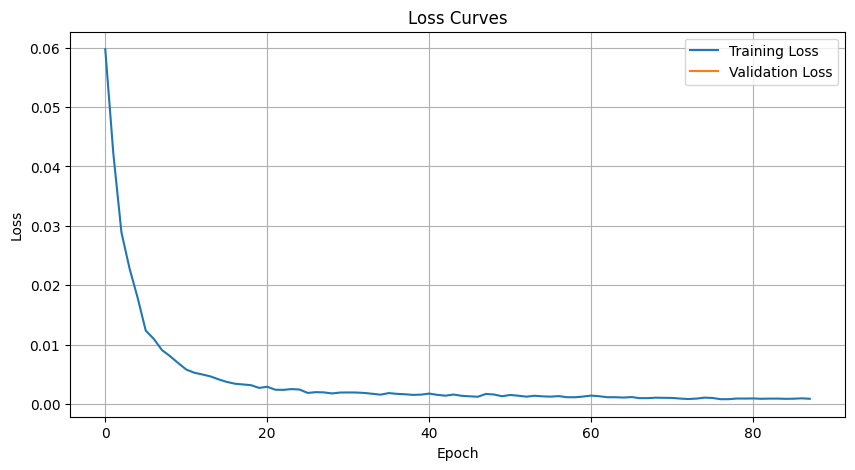

2024-11-15 20:09:36,447 - INFO - Final training loss: 0.0009
2024-11-15 20:09:36,489 - INFO - 提前5天预报 - RMSE: 0.0276, MAE: 0.0205
2024-11-15 20:09:36,491 - INFO - 
训练提前6天预报模型
2024-11-15 20:09:44,597 - INFO - Epoch 10/200, Average Loss: 0.0082
2024-11-15 20:09:54,104 - INFO - Epoch 20/200, Average Loss: 0.0031
2024-11-15 20:10:03,811 - INFO - Epoch 30/200, Average Loss: 0.0023
2024-11-15 20:10:12,861 - INFO - Epoch 40/200, Average Loss: 0.0017
2024-11-15 20:10:21,945 - INFO - Epoch 50/200, Average Loss: 0.0014
2024-11-15 20:10:30,468 - INFO - Epoch 60/200, Average Loss: 0.0012
2024-11-15 20:10:40,405 - INFO - Epoch 70/200, Average Loss: 0.0011
2024-11-15 20:10:50,083 - INFO - Epoch 80/200, Average Loss: 0.0010
2024-11-15 20:11:00,252 - INFO - Epoch 90/200, Average Loss: 0.0008
2024-11-15 20:11:05,091 - INFO - Early stopping at epoch 95


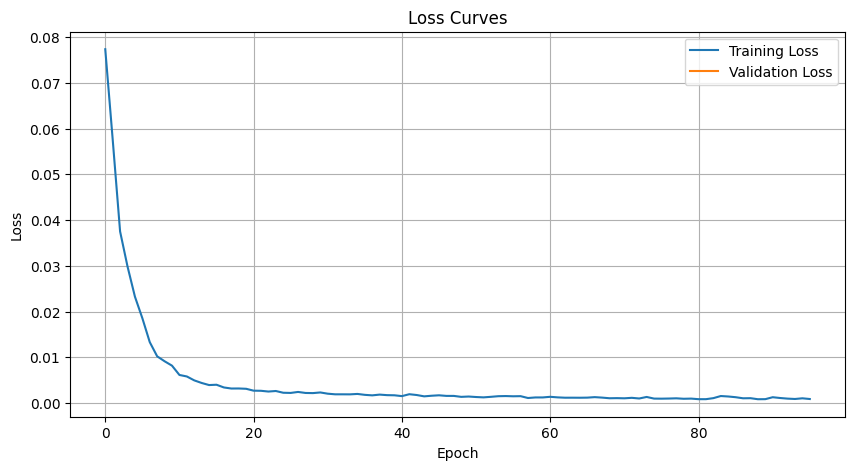

2024-11-15 20:11:05,273 - INFO - Final training loss: 0.0009
2024-11-15 20:11:05,366 - INFO - 提前6天预报 - RMSE: 0.0264, MAE: 0.0207
2024-11-15 20:11:05,369 - INFO - 
训练提前7天预报模型
2024-11-15 20:11:14,888 - INFO - Epoch 10/200, Average Loss: 0.0077
2024-11-15 20:11:26,805 - INFO - Epoch 20/200, Average Loss: 0.0037
2024-11-15 20:11:35,543 - INFO - Epoch 30/200, Average Loss: 0.0026
2024-11-15 20:11:43,703 - INFO - Epoch 40/200, Average Loss: 0.0020
2024-11-15 20:11:53,073 - INFO - Epoch 50/200, Average Loss: 0.0016
2024-11-15 20:12:01,796 - INFO - Epoch 60/200, Average Loss: 0.0013
2024-11-15 20:12:12,081 - INFO - Epoch 70/200, Average Loss: 0.0010
2024-11-15 20:12:20,828 - INFO - Epoch 80/200, Average Loss: 0.0011
2024-11-15 20:12:30,617 - INFO - Epoch 90/200, Average Loss: 0.0009
2024-11-15 20:12:34,305 - INFO - Early stopping at epoch 92


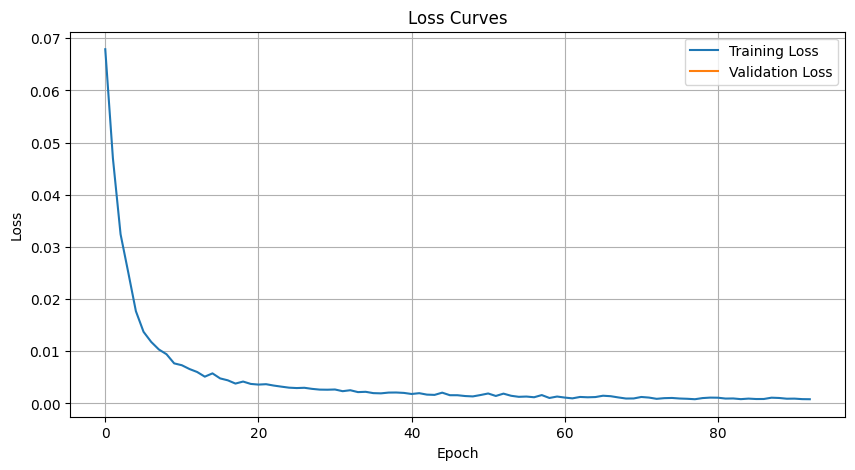

2024-11-15 20:12:34,450 - INFO - Final training loss: 0.0008
2024-11-15 20:12:34,488 - INFO - 提前7天预报 - RMSE: 0.0418, MAE: 0.0350
/tmp/ipykernel_3347/3502351650.py:299: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3347/3502351650.py:299: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3347/3502351650.py:299: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3347/3502351650.py:299: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3347/3502351650.py:299: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3347/3502351650.py:299: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/

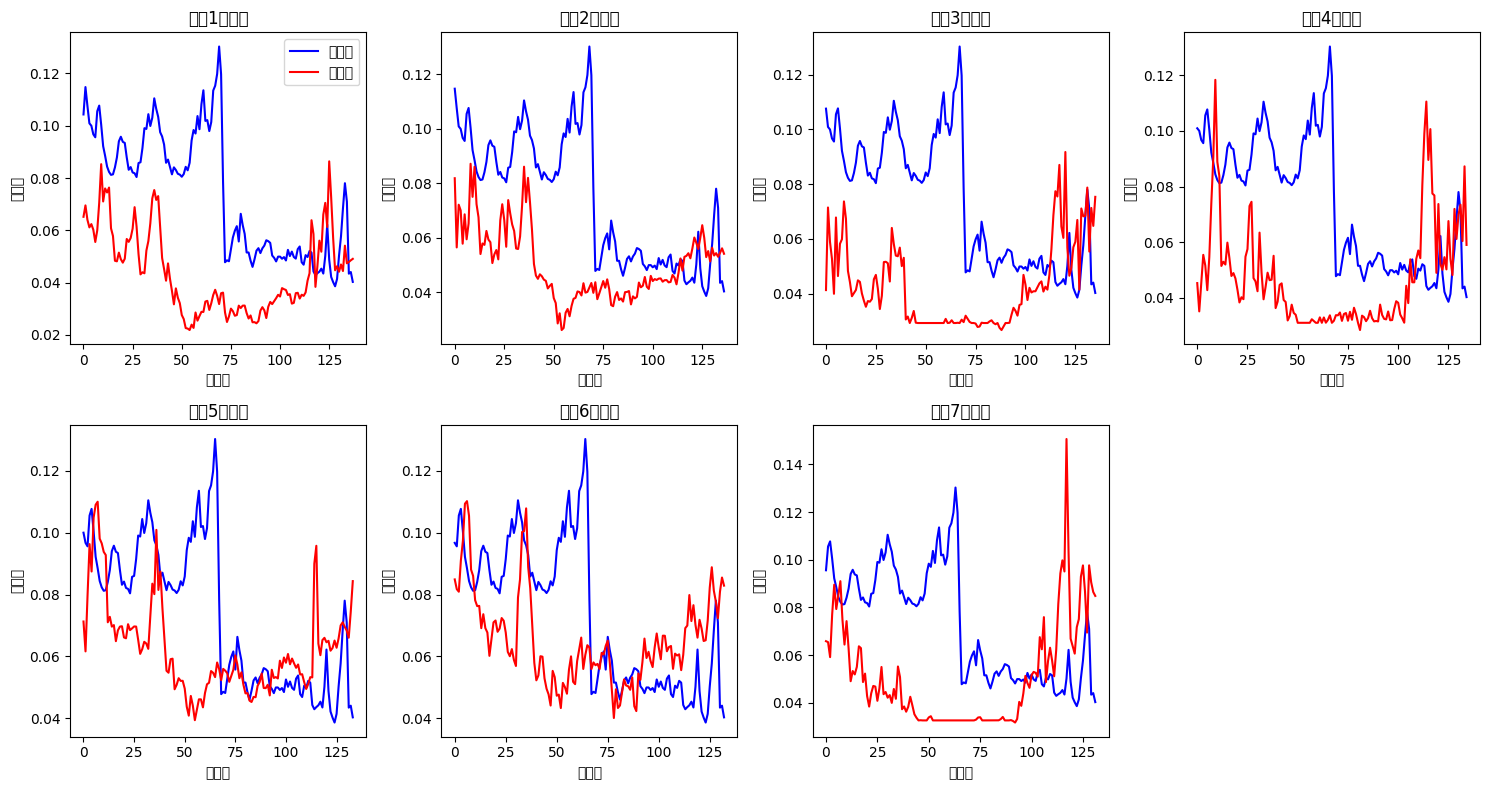

/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Us

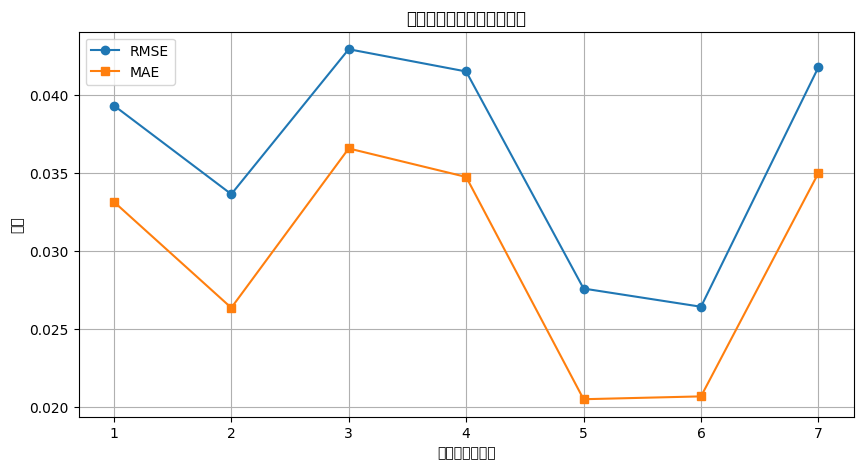

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import logging
from torch.optim.lr_scheduler import OneCycleLR

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.batch_norm1 = nn.BatchNorm1d(n_outputs)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.batch_norm2 = nn.BatchNorm1d(n_outputs)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.batch_norm1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.batch_norm2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        if self.downsample is not None:
            residual = self.downsample(residual)
            
        if out.size(2) != residual.size(2):
            min_len = min(out.size(2), residual.size(2))
            out = out[:, :, :min_len]
            residual = residual[:, :, :min_len]

        return self.relu(out + residual)

class TCNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, kernel_size=3, dropout=0.2):
        super(TCNModel, self).__init__()
        self.batch_norm = nn.BatchNorm1d(input_size)
        
        layers = []
        num_channels = [hidden_size] * num_layers
        for i in range(num_layers):
            dilation = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size,
                                      stride=1, dilation=dilation,
                                      padding=(kernel_size-1) * dilation,
                                      dropout=dropout))
        
        self.tcn = nn.Sequential(*layers)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.batch_norm(x)
        out = self.tcn(x)
        out = out[:, :, -1]
        out = self.fc_layers(out)
        return out
    
def preprocess_data(df, sequence_length, max_prediction_step=7):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

    df = df.ffill()

    if 'weather' in df.columns:
        weather_dummies = pd.get_dummies(df['weather'], prefix='weather')
        df = pd.concat([df, weather_dummies], axis=1)
        df.drop('weather', axis=1, inplace=True)

    sorted_features = sorted(feature_importance['density_mean_y'].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:10]
    density_features = [feature[0] for feature in sorted_features]
    
    available_features = [f for f in density_features if f in df.columns]
    logging.info(f"Number of density features: {len(available_features)}")
    logging.info(f"Density features: {available_features}")
    
    available_features.append('density_mean_y')
    df_features = df[available_features]

    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=available_features, index=df.index)

    train_data = df_scaled[df_scaled.index.year < 2024]
    test_data = df_scaled[df_scaled.index.year >= 2024]

    train_data_dict = {}
    test_data_dict = {}
    
    for step in range(1, max_prediction_step + 1):
        train_sequences = []
        for i in range(len(train_data) - sequence_length - step + 1):
            train_sequences.append(train_data.iloc[i:i+sequence_length+step].values)
        train_sequences = np.array(train_sequences)
        
        test_sequences = []
        for i in range(len(test_data) - sequence_length - step + 1):
            test_sequences.append(test_data.iloc[i:i+sequence_length+step].values)
        test_sequences = np.array(test_sequences)
        
        X_train = train_sequences[:, :sequence_length, :]
        y_train = train_sequences[:, -1, [available_features.index('density_mean_y')]]
        
        X_test = test_sequences[:, :sequence_length, :]
        y_test = test_sequences[:, -1, [available_features.index('density_mean_y')]]
        
        train_data_dict[step] = (X_train, y_train)
        test_data_dict[step] = (X_test, y_test)
    
    return train_data_dict, test_data_dict, scaler, available_features

def create_dataloaders(X_train, y_train, X_test, y_test, batch_size):
    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs):
    model.train()
    best_loss = float('inf')
    patience = 15
    no_improve = 0
    min_delta = 0.0001
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if avg_loss < best_loss - min_delta:
            best_loss = avg_loss
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve >= patience:
            logging.info(f'Early stopping at epoch {epoch}')
            break
            
        if (epoch + 1) % 10 == 0:
            logging.info(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    logging.info(f'Final training loss: {train_losses[-1]:.4f}')
    if val_losses:
        logging.info(f'Final validation loss: {val_losses[-1]:.4f}')

def evaluate_lstm_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in test_loader:
            output = model(inputs)
            predictions.append(output.numpy())
            targets.append(target.numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    return predictions, targets

def plot_forecast(targets, predictions, title='Prediction Results', start_idx=0, end_idx=None):
    if end_idx is None:
        end_idx = len(targets)
        
    plt.figure(figsize=(12, 5))
    plt.plot(targets[start_idx:end_idx], label='Actual Density', color='blue')
    plt.plot(predictions[start_idx:end_idx], label='Predicted Density', color='red')
    plt.title('Algae Density Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    try:
        df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
        logging.info("Successfully loaded data file")

        batch_size = 32
        hidden_size = 128
        num_layers = 3
        output_size = 1
        criterion = nn.HuberLoss()
        epochs = 200
        max_prediction_step = 7
        sequence_length = 14

        logging.info(f"Start training model, sequence length: {sequence_length}, prediction steps: {max_prediction_step}")
        train_data_dict, test_data_dict, scaler, features = preprocess_data(
            df, sequence_length, max_prediction_step)
        
        input_size = len(features)
        logging.info(f"特征数量: {input_size}")
        logging.info(f"特征列表: {features}")
        
        results = {}
        
        for step in range(1, max_prediction_step + 1):
            logging.info(f"\n训练提前{step}天预报模型")
            
            X_train, y_train = train_data_dict[step]
            X_test, y_test = test_data_dict[step]
            
            train_loader, test_loader = create_dataloaders(
                X_train, y_train, X_test, y_test, batch_size)
            
            model = TCNModel(input_size, hidden_size, num_layers, output_size, 
                           kernel_size=3, dropout=0.2)
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.001)
            scheduler = OneCycleLR(optimizer, max_lr=0.0005, epochs=epochs,
                                 steps_per_epoch=len(train_loader),
                                 pct_start=0.3, div_factor=10.0)
            
            train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs)
            predictions, targets = evaluate_lstm_model(model, test_loader)
            
            rmse = np.sqrt(mean_squared_error(targets, predictions))
            mae = mean_absolute_error(targets, predictions)
            
            results[step] = {
                'predictions': predictions,
                'targets': targets,
                'rmse': rmse,
                'mae': mae
            }
            
            logging.info(f"提前{step}天预报 - RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        
        plt.figure(figsize=(15, 8))
        for step in range(1, max_prediction_step + 1):
            plt.subplot(2, 4, step)
            plt.plot(results[step]['targets'], label='实际值', color='blue')
            plt.plot(results[step]['predictions'], label='预测值', color='red')
            plt.title(f'提前{step}天预报')
            plt.xlabel('时间步')
            plt.ylabel('藻密度')
            if step == 1:
                plt.legend()
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10, 5))
        steps = list(results.keys())
        rmse_values = [results[step]['rmse'] for step in steps]
        mae_values = [results[step]['mae'] for step in steps]
        
        plt.plot(steps, rmse_values, 'o-', label='RMSE')
        plt.plot(steps, mae_values, 's-', label='MAE')
        plt.xlabel('预测步长（天）')
        plt.ylabel('误差')
        plt.title('预测误差随预测步长的变化')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        logging.error(f"程序错误: {str(e)}")
        import traceback
        logging.error(traceback.format_exc())

if __name__ == "__main__":
    main()

2024-11-15 20:13:13,201 - INFO - Successfully loaded data file
2024-11-15 20:13:13,202 - INFO - 开始加载数据并预处理...
2024-11-15 20:13:13,212 - INFO - 环境特征数量: 10
2024-11-15 20:13:13,213 - INFO - 环境特征: ['temperature', 'min_temperature', 'max_temperature', 'oxygen', 'TN', 'conductivity', 'pH', 'aqi', 'aqiLevel', 'TP']
2024-11-15 20:13:13,213 - INFO - 历史特征: ['density_mean_y', 'density_upper_y', 'density_lower_y', 'chla_mean', 'chla_upper', 'chla_lower']
2024-11-15 20:13:13,395 - INFO - 输入特征维度: 16
2024-11-15 20:13:13,396 - INFO - 
训练提前1天预报模型
2024-11-15 20:13:25,497 - INFO - Epoch 10/200, Average Loss: 0.0066
2024-11-15 20:13:35,357 - INFO - Epoch 20/200, Average Loss: 0.0023
2024-11-15 20:13:45,907 - INFO - Epoch 30/200, Average Loss: 0.0020
2024-11-15 20:13:54,782 - INFO - Epoch 40/200, Average Loss: 0.0013
2024-11-15 20:14:03,447 - INFO - Epoch 50/200, Average Loss: 0.0011
2024-11-15 20:14:11,664 - INFO - Epoch 60/200, Average Loss: 0.0010
2024-11-15 20:14:18,984 - INFO - Epoch 70/200, Average L

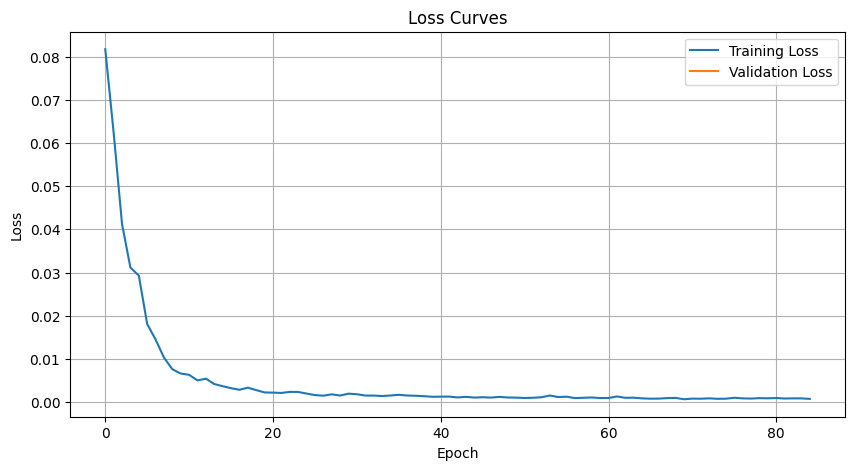

2024-11-15 20:14:32,843 - INFO - Final training loss: 0.0008
2024-11-15 20:14:32,954 - INFO - 提前1天预报 - RMSE: 0.0266, MAE: 0.0213
2024-11-15 20:14:32,957 - INFO - 
训练提前2天预报模型
2024-11-15 20:14:42,871 - INFO - Epoch 10/200, Average Loss: 0.0081
2024-11-15 20:14:52,575 - INFO - Epoch 20/200, Average Loss: 0.0026
2024-11-15 20:15:01,407 - INFO - Epoch 30/200, Average Loss: 0.0017
2024-11-15 20:15:10,239 - INFO - Epoch 40/200, Average Loss: 0.0013
2024-11-15 20:15:19,791 - INFO - Epoch 50/200, Average Loss: 0.0016
2024-11-15 20:15:28,295 - INFO - Epoch 60/200, Average Loss: 0.0010
2024-11-15 20:15:29,852 - INFO - Early stopping at epoch 61


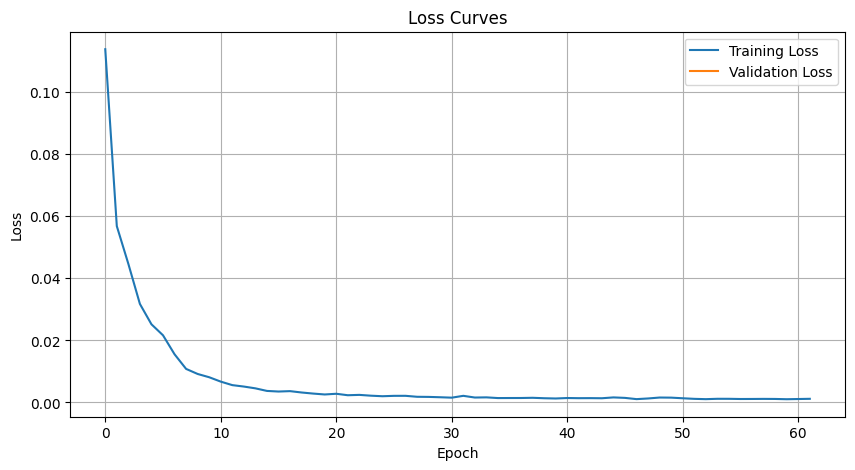

2024-11-15 20:15:30,006 - INFO - Final training loss: 0.0012
2024-11-15 20:15:30,044 - INFO - 提前2天预报 - RMSE: 0.0298, MAE: 0.0244
2024-11-15 20:15:30,046 - INFO - 
训练提前3天预报模型
2024-11-15 20:15:38,142 - INFO - Epoch 10/200, Average Loss: 0.0047
2024-11-15 20:15:45,382 - INFO - Epoch 20/200, Average Loss: 0.0023
2024-11-15 20:15:53,959 - INFO - Epoch 30/200, Average Loss: 0.0018
2024-11-15 20:16:03,619 - INFO - Epoch 40/200, Average Loss: 0.0013
2024-11-15 20:16:15,694 - INFO - Epoch 50/200, Average Loss: 0.0012
2024-11-15 20:16:24,830 - INFO - Epoch 60/200, Average Loss: 0.0010
2024-11-15 20:16:34,540 - INFO - Epoch 70/200, Average Loss: 0.0009
2024-11-15 20:16:44,333 - INFO - Epoch 80/200, Average Loss: 0.0012
2024-11-15 20:16:45,241 - INFO - Early stopping at epoch 80


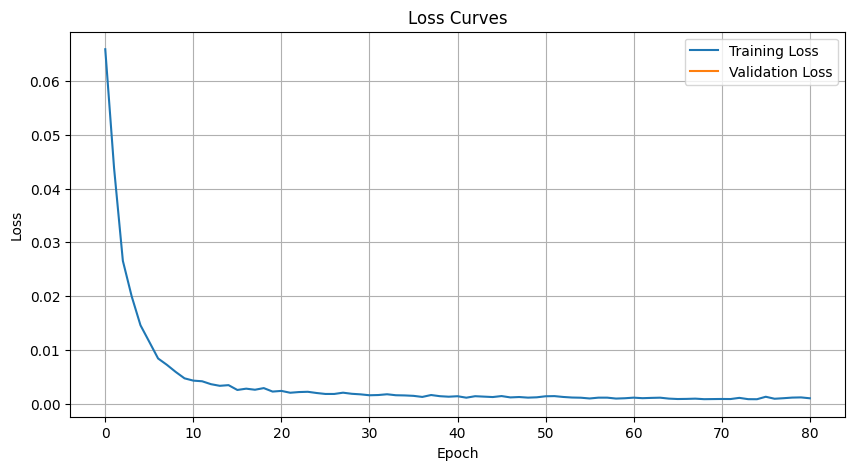

2024-11-15 20:16:45,385 - INFO - Final training loss: 0.0010
2024-11-15 20:16:45,455 - INFO - 提前3天预报 - RMSE: 0.0318, MAE: 0.0258
2024-11-15 20:16:45,457 - INFO - 
训练提前4天预报模型
2024-11-15 20:16:54,482 - INFO - Epoch 10/200, Average Loss: 0.0091
2024-11-15 20:17:03,577 - INFO - Epoch 20/200, Average Loss: 0.0040
2024-11-15 20:17:14,074 - INFO - Epoch 30/200, Average Loss: 0.0026
2024-11-15 20:17:23,919 - INFO - Epoch 40/200, Average Loss: 0.0020
2024-11-15 20:17:34,124 - INFO - Epoch 50/200, Average Loss: 0.0015
2024-11-15 20:17:43,566 - INFO - Epoch 60/200, Average Loss: 0.0013
2024-11-15 20:17:54,684 - INFO - Epoch 70/200, Average Loss: 0.0012
2024-11-15 20:18:00,532 - INFO - Early stopping at epoch 76


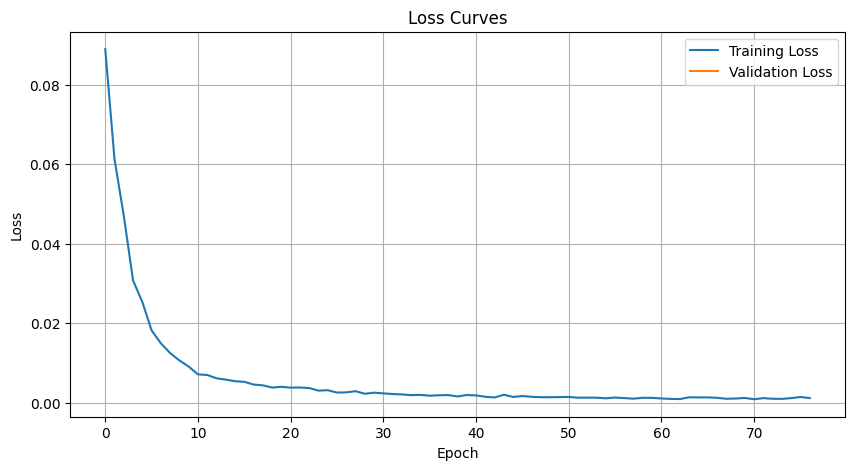

2024-11-15 20:18:00,684 - INFO - Final training loss: 0.0012
2024-11-15 20:18:00,780 - INFO - 提前4天预报 - RMSE: 0.0366, MAE: 0.0298
2024-11-15 20:18:00,784 - INFO - 
训练提前5天预报模型
2024-11-15 20:18:10,659 - INFO - Epoch 10/200, Average Loss: 0.0067
2024-11-15 20:18:18,001 - INFO - Epoch 20/200, Average Loss: 0.0033
2024-11-15 20:18:24,877 - INFO - Epoch 30/200, Average Loss: 0.0018
2024-11-15 20:18:31,536 - INFO - Epoch 40/200, Average Loss: 0.0015
2024-11-15 20:18:39,035 - INFO - Epoch 50/200, Average Loss: 0.0011
2024-11-15 20:18:48,408 - INFO - Epoch 60/200, Average Loss: 0.0012
2024-11-15 20:18:58,039 - INFO - Epoch 70/200, Average Loss: 0.0011
2024-11-15 20:19:05,928 - INFO - Early stopping at epoch 79


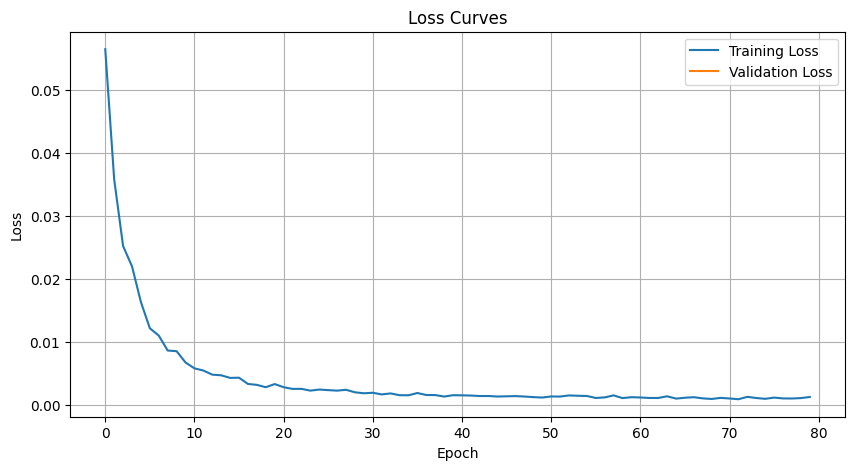

2024-11-15 20:19:06,071 - INFO - Final training loss: 0.0012
2024-11-15 20:19:06,111 - INFO - 提前5天预报 - RMSE: 0.0366, MAE: 0.0301
2024-11-15 20:19:06,112 - INFO - 
训练提前6天预报模型
2024-11-15 20:19:15,260 - INFO - Epoch 10/200, Average Loss: 0.0072
2024-11-15 20:19:24,253 - INFO - Epoch 20/200, Average Loss: 0.0030
2024-11-15 20:19:33,322 - INFO - Epoch 30/200, Average Loss: 0.0020
2024-11-15 20:19:43,016 - INFO - Epoch 40/200, Average Loss: 0.0014
2024-11-15 20:19:52,938 - INFO - Epoch 50/200, Average Loss: 0.0015
2024-11-15 20:20:01,615 - INFO - Epoch 60/200, Average Loss: 0.0009
2024-11-15 20:20:11,400 - INFO - Epoch 70/200, Average Loss: 0.0011
2024-11-15 20:20:16,467 - INFO - Early stopping at epoch 74


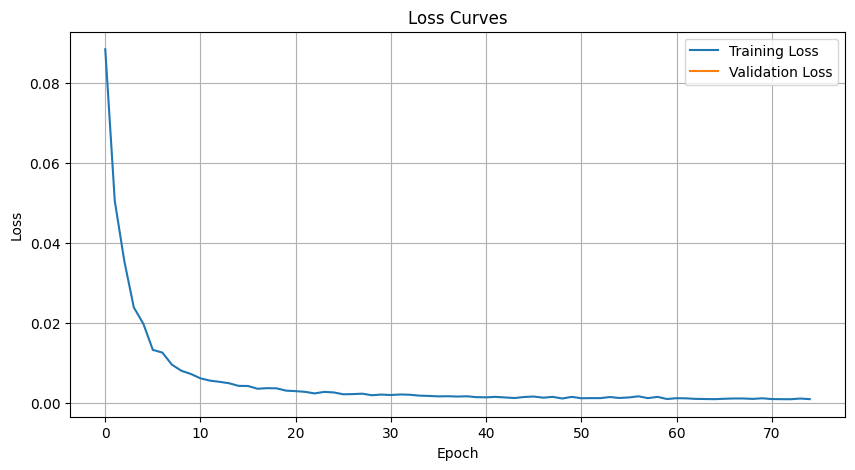

2024-11-15 20:20:16,614 - INFO - Final training loss: 0.0009
2024-11-15 20:20:16,660 - INFO - 提前6天预报 - RMSE: 0.0429, MAE: 0.0358
2024-11-15 20:20:16,662 - INFO - 
训练提前7天预报模型
2024-11-15 20:20:26,833 - INFO - Epoch 10/200, Average Loss: 0.0105
2024-11-15 20:20:36,420 - INFO - Epoch 20/200, Average Loss: 0.0041
2024-11-15 20:20:45,545 - INFO - Epoch 30/200, Average Loss: 0.0026
2024-11-15 20:20:55,054 - INFO - Epoch 40/200, Average Loss: 0.0018
2024-11-15 20:21:04,684 - INFO - Epoch 50/200, Average Loss: 0.0017
2024-11-15 20:21:13,957 - INFO - Epoch 60/200, Average Loss: 0.0012
2024-11-15 20:21:23,633 - INFO - Epoch 70/200, Average Loss: 0.0012
2024-11-15 20:21:31,364 - INFO - Epoch 80/200, Average Loss: 0.0009
2024-11-15 20:21:41,039 - INFO - Epoch 90/200, Average Loss: 0.0009
2024-11-15 20:21:46,831 - INFO - Early stopping at epoch 97


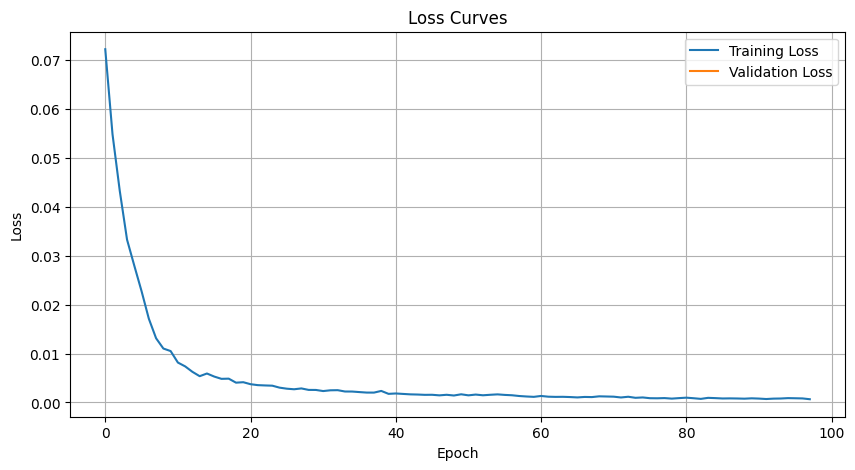

2024-11-15 20:21:46,965 - INFO - Final training loss: 0.0007
2024-11-15 20:21:47,002 - INFO - 提前7天预报 - RMSE: 0.0456, MAE: 0.0387
/tmp/ipykernel_3347/817024061.py:307: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3347/817024061.py:307: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3347/817024061.py:307: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3347/817024061.py:307: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3347/817024061.py:307: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3347/817024061.py:307: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/tmp/ip

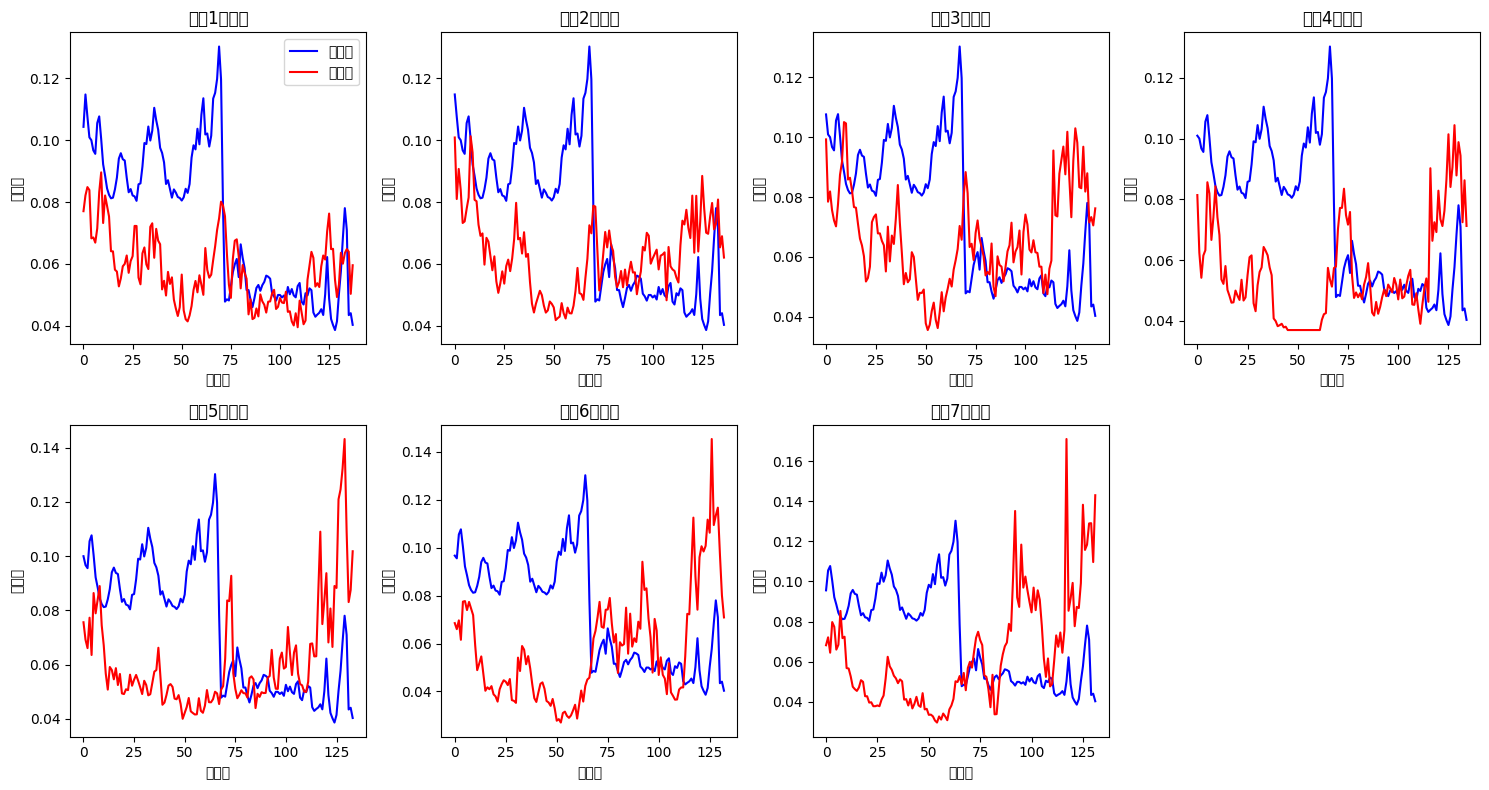

/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Us

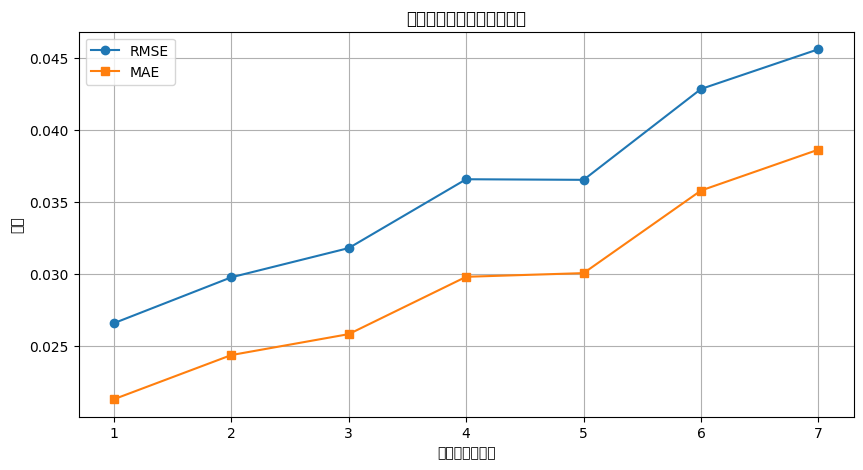

: 

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import logging
from torch.optim.lr_scheduler import OneCycleLR

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.batch_norm1 = nn.BatchNorm1d(n_outputs)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.batch_norm2 = nn.BatchNorm1d(n_outputs)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.batch_norm1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.batch_norm2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        if self.downsample is not None:
            residual = self.downsample(residual)
            
        if out.size(2) != residual.size(2):
            min_len = min(out.size(2), residual.size(2))
            out = out[:, :, :min_len]
            residual = residual[:, :, :min_len]

        return self.relu(out + residual)

class TCNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, kernel_size=3, dropout=0.2):
        super(TCNModel, self).__init__()
        self.batch_norm = nn.BatchNorm1d(input_size)
        
        layers = []
        num_channels = [hidden_size] * num_layers
        for i in range(num_layers):
            dilation = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size,
                                      stride=1, dilation=dilation,
                                      padding=(kernel_size-1) * dilation,
                                      dropout=dropout))
        
        self.tcn = nn.Sequential(*layers)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.batch_norm(x)
        out = self.tcn(x)
        out = out[:, :, -1]
        out = self.fc_layers(out)
        return out
    
def preprocess_data(df, sequence_length, max_prediction_step=7):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

    df = df.ffill()

    if 'weather' in df.columns:
        weather_dummies = pd.get_dummies(df['weather'], prefix='weather')
        df = pd.concat([df, weather_dummies], axis=1)
        df.drop('weather', axis=1, inplace=True)

    # 获取Top10环境特征
    sorted_features = sorted(feature_importance['density_mean_y'].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:10]
    env_features = [feature[0] for feature in sorted_features]
    available_env_features = [f for f in env_features if f in df.columns]
    
    # 添加历史藻密度和叶绿素a特征
    history_features = ['density_mean_y', 'density_upper_y', 'density_lower_y',
                       'chla_mean', 'chla_upper', 'chla_lower']
    all_features = available_env_features + history_features
    
    logging.info(f"环境特征数量: {len(available_env_features)}")
    logging.info(f"环境特征: {available_env_features}")
    logging.info(f"历史特征: {history_features}")
    
    df_features = df[all_features]

    # 对所有特征进行归一化
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_features), 
                           columns=all_features, 
                           index=df.index)

    train_data = df_scaled[df_scaled.index.year < 2024]
    test_data = df_scaled[df_scaled.index.year >= 2024]

    train_data_dict = {}
    test_data_dict = {}
    
    for step in range(1, max_prediction_step + 1):
        train_sequences = []
        for i in range(len(train_data) - sequence_length - step + 1):
            train_sequences.append(train_data.iloc[i:i+sequence_length+step].values)
        train_sequences = np.array(train_sequences)
        
        test_sequences = []
        for i in range(len(test_data) - sequence_length - step + 1):
            test_sequences.append(test_data.iloc[i:i+sequence_length+step].values)
        test_sequences = np.array(test_sequences)
        
        X_train = train_sequences[:, :sequence_length, :]
        y_train = train_sequences[:, -1, [all_features.index('density_mean_y')]]
        
        X_test = test_sequences[:, :sequence_length, :]
        y_test = test_sequences[:, -1, [all_features.index('density_mean_y')]]
        
        train_data_dict[step] = (X_train, y_train)
        test_data_dict[step] = (X_test, y_test)
    
    return train_data_dict, test_data_dict, scaler, all_features

def create_dataloaders(X_train, y_train, X_test, y_test, batch_size):
    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs):
    model.train()
    best_loss = float('inf')
    patience = 15
    no_improve = 0
    min_delta = 0.0001
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if avg_loss < best_loss - min_delta:
            best_loss = avg_loss
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve >= patience:
            logging.info(f'Early stopping at epoch {epoch}')
            break
            
        if (epoch + 1) % 10 == 0:
            logging.info(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    logging.info(f'Final training loss: {train_losses[-1]:.4f}')
    if val_losses:
        logging.info(f'Final validation loss: {val_losses[-1]:.4f}')

def evaluate_lstm_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in test_loader:
            output = model(inputs)
            predictions.append(output.numpy())
            targets.append(target.numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    return predictions, targets

def plot_forecast(targets, predictions, title='Prediction Results', start_idx=0, end_idx=None):
    if end_idx is None:
        end_idx = len(targets)
        
    plt.figure(figsize=(12, 5))
    plt.plot(targets[start_idx:end_idx], label='Actual Density', color='blue')
    plt.plot(predictions[start_idx:end_idx], label='Predicted Density', color='red')
    plt.title('Algae Density Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    try:
        df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
        logging.info("Successfully loaded data file")

        batch_size = 32
        hidden_size = 128
        num_layers = 3
        output_size = 1
        criterion = nn.HuberLoss()
        epochs = 200
        max_prediction_step = 7
        sequence_length = 14

        logging.info("开始加载数据并预处理...")
        train_data_dict, test_data_dict, scaler, features = preprocess_data(
            df, sequence_length, max_prediction_step)
        
        input_size = len(features)  # 输入特征维度会增加
        logging.info(f"输入特征维度: {input_size}")
        
        results = {}
        
        for step in range(1, max_prediction_step + 1):
            logging.info(f"\n训练提前{step}天预报模型")
            
            X_train, y_train = train_data_dict[step]
            X_test, y_test = test_data_dict[step]
            
            train_loader, test_loader = create_dataloaders(
                X_train, y_train, X_test, y_test, batch_size)
            
            model = TCNModel(input_size, hidden_size, num_layers, output_size, 
                           kernel_size=3, dropout=0.2)
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.001)
            scheduler = OneCycleLR(optimizer, max_lr=0.0005, epochs=epochs,
                                 steps_per_epoch=len(train_loader),
                                 pct_start=0.3, div_factor=10.0)
            
            train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs)
            predictions, targets = evaluate_lstm_model(model, test_loader)
            
            rmse = np.sqrt(mean_squared_error(targets, predictions))
            mae = mean_absolute_error(targets, predictions)
            
            results[step] = {
                'predictions': predictions,
                'targets': targets,
                'rmse': rmse,
                'mae': mae
            }
            
            logging.info(f"提前{step}天预报 - RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        
        plt.figure(figsize=(15, 8))
        for step in range(1, max_prediction_step + 1):
            plt.subplot(2, 4, step)
            plt.plot(results[step]['targets'], label='实际值', color='blue')
            plt.plot(results[step]['predictions'], label='预测值', color='red')
            plt.title(f'提前{step}天预报')
            plt.xlabel('时间步')
            plt.ylabel('藻密度')
            if step == 1:
                plt.legend()
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10, 5))
        steps = list(results.keys())
        rmse_values = [results[step]['rmse'] for step in steps]
        mae_values = [results[step]['mae'] for step in steps]
        
        plt.plot(steps, rmse_values, 'o-', label='RMSE')
        plt.plot(steps, mae_values, 's-', label='MAE')
        plt.xlabel('预测步长（天）')
        plt.ylabel('误差')
        plt.title('预测误差随预测步长的变化')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        logging.error(f"程序错误: {str(e)}")
        import traceback
        logging.error(traceback.format_exc())

if __name__ == "__main__":
    main()